#### Домашнее задание №4 
## Модели авторегрессии условной гетероскедантичности

- Выберите ряд и постройте его модель GARCH.
- Не обязательное дз. Попробуйте спрогнозировать график классическим ML
___

1. Загрузка библиотек (копия из предыдущего ДЗ)
2. Определение базовых функций для исследования рядов и их предсказания (копия из предыдущего ДЗ)
3. Загрузка датасета (исследуем датасет с уровнем выброса CO2 в атмосферу в районе вулкана Мауна-Лоу на Гавайях)  
5. Применение модели GARCH  
6. Используем классический ML  

## 1. Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 2. Определяем функции
За основу берем функции из лекционного ноутбука

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', plot_title='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(plot_title)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [5]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl


## 3. Загрузка и предварительный анализ датасета

Поскольку дальше использовать датасеты из лекционных примеров кажется не вполне спортивным, я решил использовать другие источники данных.  
В состав библиотеки statsmodels входит коллекция датасетов, которые можно использовать для анализа.  
Одним из датасетов, который показался мне интересным, является El Nino - Sea Surface Temperatures
Этот датасет описан на сайте библиотеки: https://www.statsmodels.org/dev/datasets/generated/elnino.html

##### Загружаем датасет и смотрим его характеристики:

In [6]:
data = sm.datasets.elnino.load_pandas()
df = data.data
df_tmp = df.copy()
df_tmp.drop('YEAR', inplace=True, axis=1)
df_tmp.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
2,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
3,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
4,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30


In [7]:
df1 = df.set_index('YEAR')
df1 = df1.stack()
df1 = df1.reset_index()
df1 = df1.rename(columns = {'level_1':"Labels",
                   0: 'Values'})
df1

,YEAR,Labels,Values
0,1950.0,JAN,23.11
1,1950.0,FEB,24.20
2,1950.0,MAR,25.37
3,1950.0,APR,23.86
4,1950.0,MAY,23.03
...,...,...,...
727,2010.0,AUG,19.49
728,2010.0,SEP,19.28
729,2010.0,OCT,19.73
730,2010.0,NOV,20.44


In [8]:
seria = df1['Values']
seria

0      23.11
1      24.20
2      25.37
3      23.86
4      23.03
       ...  
727    19.49
728    19.28
729    19.73
730    20.44
731    22.07
Name: Values, Length: 732, dtype: float64

## 4. Предварительный визуальный анализ

In [11]:
print(f'Количество пропусков в датасете NaN = {seria.isna().sum()}')

Количество пропусков в датасете NaN = 0


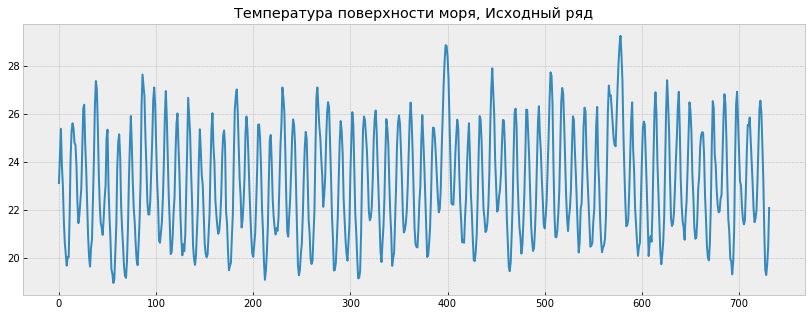

In [47]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 5))
    seria.plot()
    plt.title('Температура поверхности моря, Исходный ряд')

Results of Dickey-Fuller Test:
Test Statistic                -5.693157e+00
p-value                        7.984873e-07
#Lags Used                     1.800000e+01
Number of Observations Used    7.130000e+02
Critical Value (1%)           -3.439555e+00
Critical Value (5%)           -2.865602e+00
Critical Value (10%)          -2.568933e+00
dtype: float64


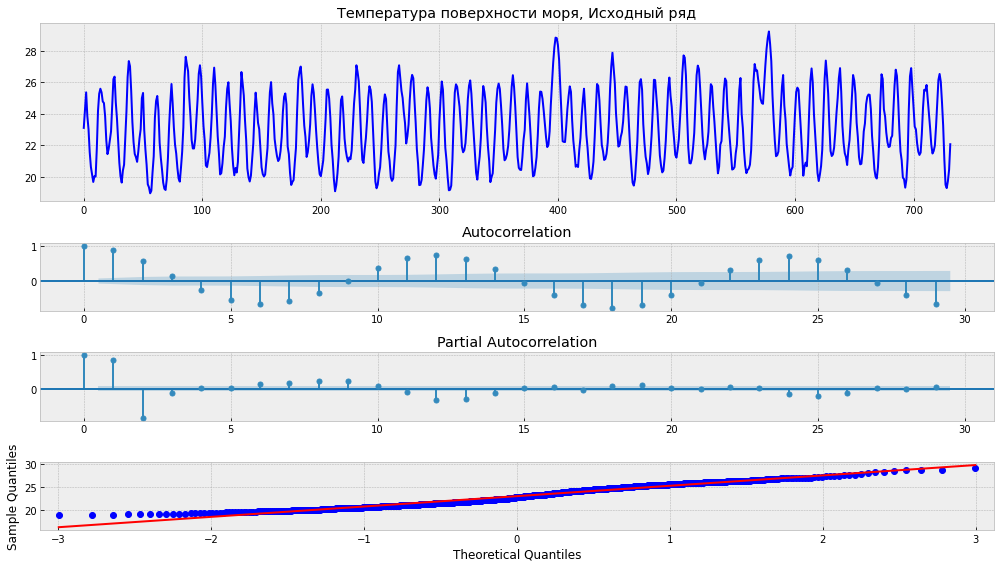

In [10]:
tsplot(seria.copy(), plot_title='Температура поверхности моря, Исходный ряд')

К сожалению, этот ряд оказался стационарным (цикличность ряда убрать теперь не сложно, но мы пока не видим в этом ряду ни признаков наличия трендов, ни изменяющейся со временем дисперсии. В этой связи сложно ожидать каких-то убедительных результатов применения к этому ряду метода GARCH.
Чтобы все-таки разобраться с этим методом, я попробую искусственно преобразовать этот ряд, добавив ему как искусственный тренд, так и какую-то динамику к дисперсии.

## 5. Манипуляции с данными

##### 5.1 Промоделируем GARSH

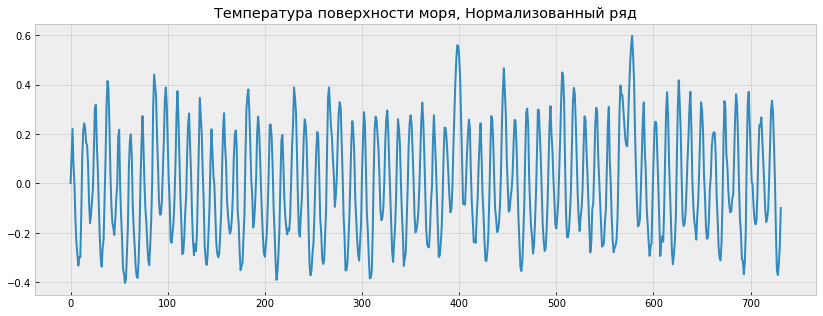

In [90]:
# Вначале нормализуем ряд
ser_mean = seria.mean()
ser_min = seria.min()
ser_max = seria.max()
seria_norm = pd.Series([(i - ser_mean)/(ser_max - ser_min) for i in seria.to_list()])

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 5))
    seria_norm.plot()
    plt.title('Температура поверхности моря, Нормализованный ряд')

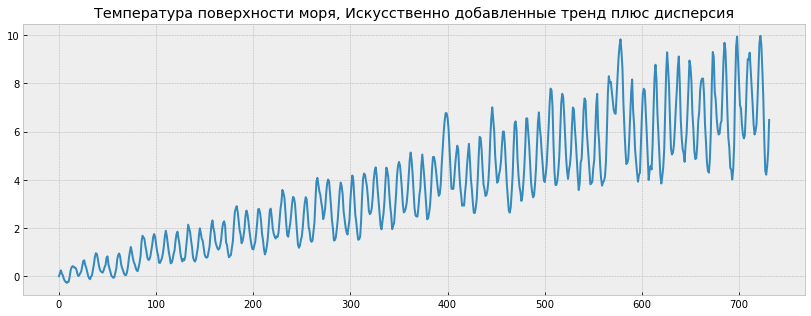

In [91]:
seria_diff = pd.Series([d*(1 + i*0.01) + i*0.01 for i, d in enumerate(seria_norm.to_list())])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 5))
    seria_diff.plot()
    plt.title('Температура поверхности моря, Искусственно добавленные тренд плюс дисперсия')

In [86]:
# Используем ARIMA для поиска лучшего набора коэффициентов

def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(seria_diff)

aic: 18.13582 | order: (4, 1, 4)


Results of Dickey-Fuller Test:
Test Statistic                -7.560928e+00
p-value                        3.011588e-11
#Lags Used                     1.900000e+01
Number of Observations Used    7.110000e+02
Critical Value (1%)           -3.439581e+00
Critical Value (5%)           -2.865614e+00
Critical Value (10%)          -2.568939e+00
dtype: float64


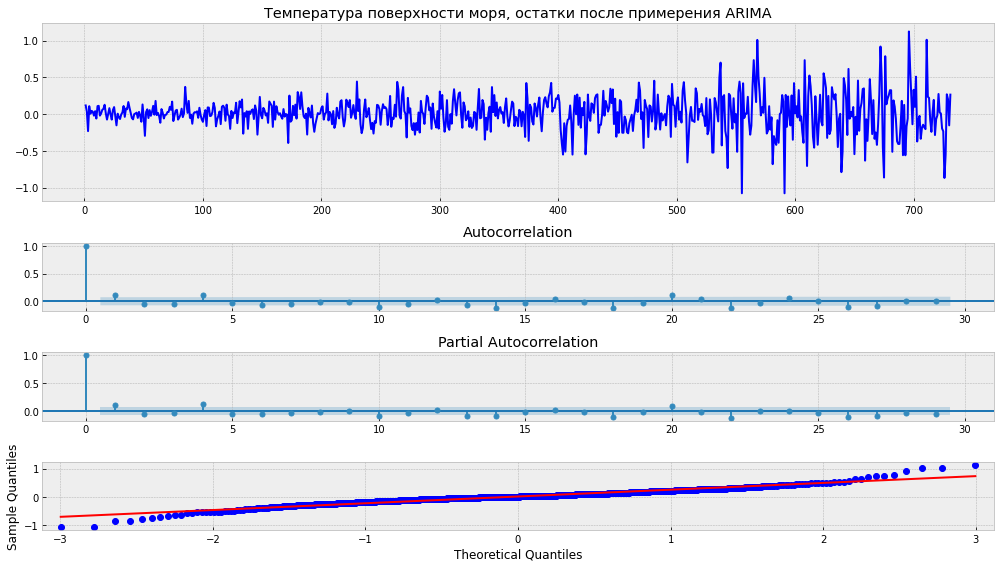

In [92]:
tsplot(mdl.resid, plot_title='Температура поверхности моря, остатки после примерения ARIMA')

In [88]:
from arch import arch_model

# Используем параметры, оказавшиеся оптимальными при использовании ARIMA
p_ = 4
o_ = 1
q_ = 4

am = arch_model(seria_diff, p=p_, o=o_, q=q_, dist='StudentsT')
res_arch = am.fit(update_freq=5, disp='off')
print(res_arch.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                      -0.139
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.139
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1444.14
Distribution:      Standardized Student's t   AIC:                           2912.29
Method:                  Maximum Likelihood   BIC:                           2967.44
                                              No. Observations:                  732
Date:                      Sat, Nov 19 2022   Df Residuals:                      720
Time:                              21:42:51   Df Model:                           12
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             2

Results of Dickey-Fuller Test:
Test Statistic                  -0.877090
p-value                          0.795423
#Lags Used                      19.000000
Number of Observations Used    712.000000
Critical Value (1%)             -3.439568
Critical Value (5%)             -2.865608
Critical Value (10%)            -2.568936
dtype: float64


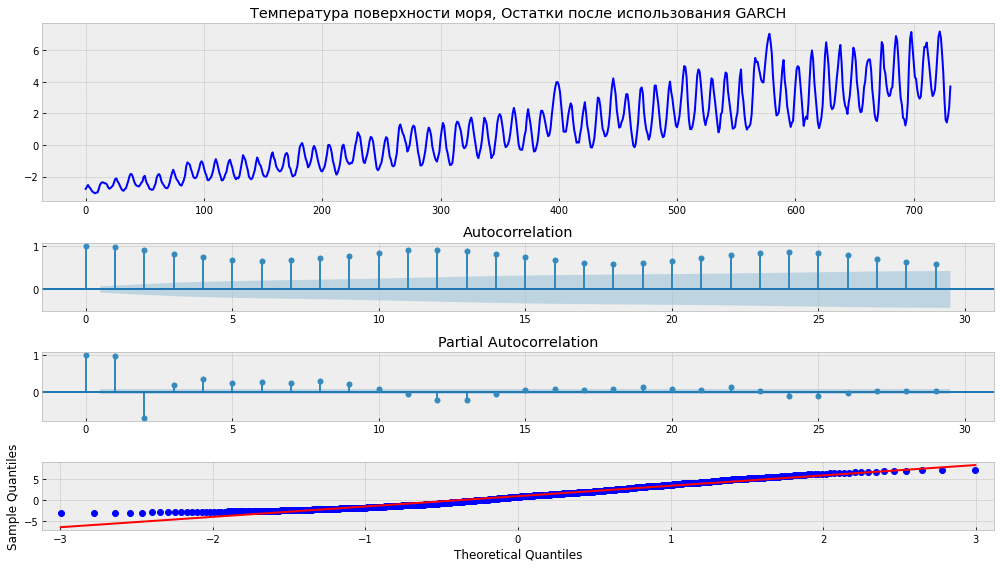

In [93]:
tsplot(res_arch.resid, plot_title='Температура поверхности моря, Остатки после использования GARCH')

Как и при выполнении предыдущего ДЗ эксперименты с GARSH не удались. Выбранный мною ряд при использовании для него GARSH, видимо, этим инструментом "не пилится". Все коэффициенты бета оказались нулевыми, первый альфа равен 1, остальные - тоже нулевые, и лишь омега с гаммой имеют небольшие значения, т.е. как минимум тренд, искусственно введенный на этапе манипуляций с исходным рядом, поймался.

## 10. Используем классический ML для исходного датасета

In [94]:
# Возьмем за основу лекционную функцию
def prepareData(data, lag_start=1, lag_end=20, test_size=0.15, drop_columns=["Month"]):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(drop_columns, axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [101]:
df = pd.DataFrame(seria)
df.columns = ['Count']
X_train, X_test, y_train, y_test = prepareData(df, lag_start=1, lag_end=15, test_size=0.3, drop_columns=[])
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
0,25.28,24.19,21.80,20.02,20.03,19.67,20.15,20.63,21.57,23.03,23.86,25.37,24.20,23.11
1,25.60,25.28,24.19,21.80,20.02,20.03,19.67,20.15,20.63,21.57,23.03,23.86,25.37,24.20
2,25.37,25.60,25.28,24.19,21.80,20.02,20.03,19.67,20.15,20.63,21.57,23.03,23.86,25.37
3,24.79,25.37,25.60,25.28,24.19,21.80,20.02,20.03,19.67,20.15,20.63,21.57,23.03,23.86
4,24.69,24.79,25.37,25.60,25.28,24.19,21.80,20.02,20.03,19.67,20.15,20.63,21.57,23.03


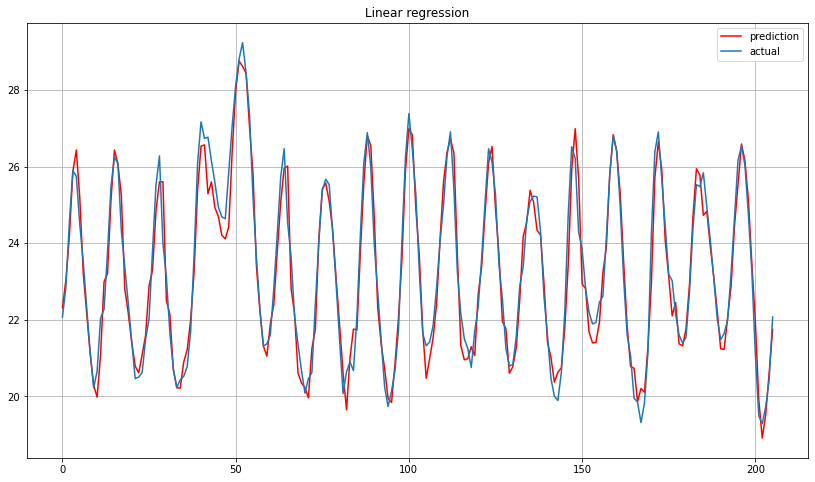

In [102]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

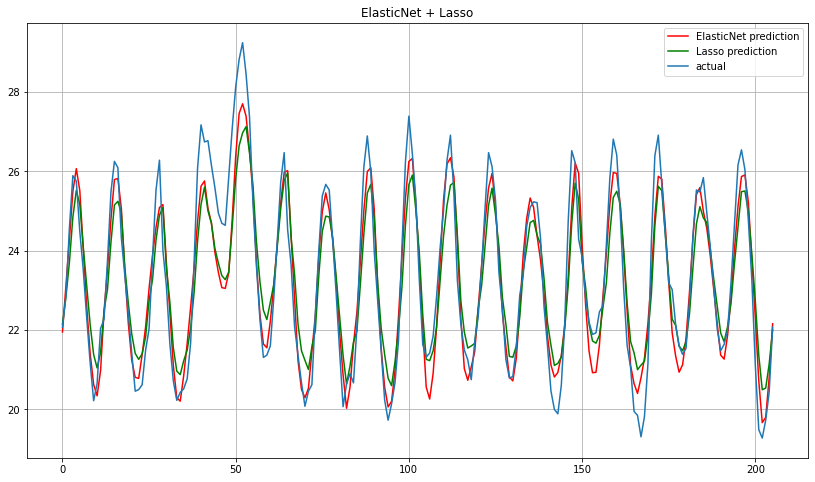

In [113]:
# Используем алгоритмы Lasso и ElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

lr2 = ElasticNet(l1_ratio=0.01, random_state=42)
lr2.fit(X_train, y_train)
prediction2 = lr2.predict(X_test)

lr3 = Lasso(random_state=42)
lr3.fit(X_train, y_train)
prediction3 = lr3.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction2, "r", label="ElasticNet prediction")
plt.plot(prediction3, "g", label="Lasso prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("ElasticNet + Lasso")
plt.grid(True);

Метод для предсказания работает неплохо, при том что в обучающей выборке данных совсем не много. Конечно, эту технологию предсказания лучше потестировать на более длинных рядах.

In [112]:
scr_01 = lr.score(X_train, y_train)
scr_02 = lr2.score(X_train, y_train)
scr_03 = lr3.score(X_train, y_train)
print(f'Коэффициенты детерминации для трех вариантов предсказаний:')
print(f'LinearRegression: {scr_01}')
print(f'ElasticNet: {scr_02}')
print(f'Lasso: {scr_03}')

Коэффициенты детерминации для трех вариантов предсказаний:
LinearRegression: 0.9584323079657786
ElasticNet: 0.9154600675438757
Lasso: 0.844731682241749


К сожалению ничего принципиально нового по сравнению с результатами, полученными в предыдущем ДЗ. я при выполнении этой домашки не увидел.